In [1]:
from google.colab import drive
import os
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Colab Notebooks/final_project')

Mounted at /content/drive


In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.models import resnet50
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "mps")
device

device(type='cuda')

## method 2

In [3]:
class ResNet50(nn.Module):
    def __init__(self, projection_dim=128):
        super(ResNet50, self).__init__()
        self.resnet50 = models.resnet50(pretrained=False)
        self.resnet50.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.resnet50.maxpool = nn.Identity()
        feature_dim = self.resnet50.fc.in_features
        self.resnet50.fc = nn.Sequential(
            nn.Linear(feature_dim, 256),
            nn.ReLU(),
            nn.Linear(256, projection_dim)
        )

    def forward(self, x):
        projection = self.resnet50(x)
        return projection

In [4]:
def color_distortion(s=0.5):
    color_jitter = transforms.ColorJitter(0.8*s, 0.8*s, 0.8*s, 0.2*s)
    rnd_color_jitter = transforms.RandomApply([color_jitter], p=0.8)
    rnd_gray = transforms.RandomGrayscale(p=0.2)
    color_distort = transforms.Compose([rnd_color_jitter, rnd_gray])
    return color_distort

# Set the strength of color distortion
s = 0.5

# train dataset
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(32),
    transforms.RandomHorizontalFlip(),
    color_distortion(s),
    transforms.ToTensor(),
    # transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))
])
# test_transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))
# ])
test_transform = transforms.Compose([
    transforms.RandomResizedCrop(32),
    transforms.RandomHorizontalFlip(),
    color_distortion(s),
    transforms.ToTensor(),
    # transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))
])

In [5]:
from torchvision.datasets import CIFAR10
from PIL import Image
# from dataset import CIFAR10Pair, test_CIFAR10Pair

class CIFAR10Pair(CIFAR10):
    def __getitem__(self, index):
        img, target = self.data[index], self.targets[index]
        img = Image.fromarray(img)
        # Apply transformations twice to get a pair of different augmentations
        img1 = train_transform(img)
        img2 = train_transform(img)
        return img1, img2, target

class test_CIFAR10Pair(CIFAR10):
    def __getitem__(self, index):
        img, target = self.data[index], self.targets[index]
        img = Image.fromarray(img)
        # Apply transformations twice to get a pair of different augmentations
        img1 = test_transform(img)
        img2 = test_transform(img)
        return img1, img2, target

# Initialize the CIFAR-10 Pair dataset
train_dataset = CIFAR10Pair(root='./cifar10', train=True, download=True)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2, pin_memory=True, drop_last=True)

# # Initialize the CIFAR-10 Pair dataset
test_dataset = test_CIFAR10Pair(root='./cifar10', train=False, download=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2, pin_memory=True, drop_last=True)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
def nt_xent_loss(z_i, z_j, temperature):
    """
    Compute the NT-Xent loss.

    Arguments:
    z_i, z_j -- Representations of positive pairs. Each should be of shape (batch_size, feature_size).
    temperature -- A temperature scaling parameter.

    Returns:
    Loss computed from the batch of representations.
    """
    N, Z = z_i.shape  # Batch size and feature dimension

    # Normalize the representations
    z_i = F.normalize(z_i, p=2, dim=1)
    z_j = F.normalize(z_j, p=2, dim=1)

    # Concatenate the representations
    representations = torch.cat([z_i, z_j], dim=0)

    # Compute cosine similarity
    similarity_matrix = torch.matmul(representations, representations.T)

    # Create the mask for positive samples
    l_pos = torch.diag(similarity_matrix, N)
    r_pos = torch.diag(similarity_matrix, -N)
    positives = torch.cat([l_pos, r_pos]).view(2 * N, 1)

    # Mask for removing the similarity of each element with itself
    diag_mask = ~(torch.eye(2 * N).bool())

    # Extract the negatives
    negatives = similarity_matrix[diag_mask].view(2 * N, -1)

    # Combine positives with negatives
    logits = torch.cat([positives, negatives], dim=1)

    # Apply temperature scaling
    logits /= temperature

    # Labels: positives are the first elements
    labels = torch.zeros(2 * N).to(z_i.device).long()

    # Calculate the cross-entropy loss
    loss = F.cross_entropy(logits, labels)

    return loss


In [7]:
def contrastive_accuracy(z_i, z_j, labels):
    with torch.no_grad():
        # Compute the cosine similarity
        similarity_matrix = F.cosine_similarity(z_i.unsqueeze(1), z_j.unsqueeze(0), dim=2)

        # Get the indices of the maximum values along each row
        max_indices = similarity_matrix.max(dim=1)[1]

        # Calculate accuracy
        correct = (labels == labels[max_indices]).float()
        return correct.mean()

In [ ]:
# def contrastive_accuracy(z_i, z_j):
#     with torch.no_grad():
#         # Calculate the cosine similarity
#         similarity_matrix = torch.matmul(F.normalize(z_i, p=2, dim=1),
#                                          F.normalize(z_j, p=2, dim=1).T)

#         # For each z_i, check if the corresponding z_j is the most similar
#         max_indices = similarity_matrix.max(dim=1)[1]
#         correct_predictions = (max_indices == torch.arange(z_i.size(0)).to(z_i.device)).float()

#         # Calculate the accuracy
#         accuracy = correct_predictions.mean()

#         return accuracy


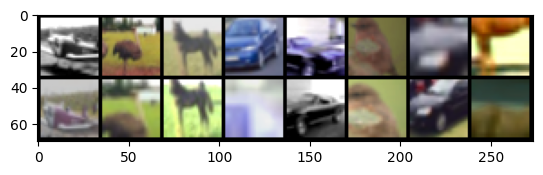

In [19]:
# Assuming train_loader is already defined and properly loaded
for batch_idx, (img1, img2, labels) in enumerate(train_loader):
    # Move the images to the same device (if you are using a device like CUDA)
    img1, img2 = img1.to(device).cpu(), img2.to(device).cpu()

    # Concatenate the first 4 images of img1 and img2
    combined_images = torch.cat((img1[:8], img2[:8]), dim=0)

    # Create a grid of images
    images_to_display = torchvision.utils.make_grid(combined_images).numpy().transpose((1, 2, 0))

    # Display the images
    plt.imshow(images_to_display)
    plt.show()

    # Only visualize the first batch
    break

In [ ]:
# Model instantiation
model = ResNet50().to(device)

# Optimizer setup
optimizer = optim.Adam(model.parameters(), lr=0.5)

# Number of training epochs
num_epochs = 200


best_val_loss = float('inf')

train_loss_list = []
train_accuracy_list = []
test_loss_list = []
test_accuracy_list = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    total_accuracy = 0

    for batch_idx, (img1, img2, labels) in enumerate(train_loader):
        img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)

        # Forward pass
        z_i = model(img1)
        z_j = model(img2)

        # Compute NT-Xent Loss
        loss = nt_xent_loss(z_i, z_j, temperature=0.5)

        # Compute accuracy
        # train_accuracy = contrastive_accuracy(z_i, z_j)
        train_accuracy = contrastive_accuracy(z_i, z_j, labels)
        total_accuracy += train_accuracy.item()


        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Print loss and accuracy every 10 batches
        if (batch_idx + 1) % 200 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_loader)}], Train Loss: {loss.item():.4f}, Train Accuracy: {train_accuracy:.4f}')

    # Average loss and accuracy for this epoch
    avg_loss = total_loss / len(train_loader)
    avg_accuracy = total_accuracy / len(train_loader)

    # Evaluate on test set
    model.eval()
    total_test_loss = 0
    total_test_accuracy = 0
    with torch.no_grad():
        for batch_idx, (img1, img2, labels) in enumerate(test_loader):
            img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)
            z_i = model(img1)
            z_j = model(img2)
            # Assuming you have a way to calculate test loss, e.g., CrossEntropyLoss for classification
            test_loss = nt_xent_loss(z_i, z_j, temperature=0.5)
            total_test_loss += test_loss.item()
            # Compute accuracy
            # test_accuracy = contrastive_accuracy(z_i, z_j)
            test_accuracy = contrastive_accuracy(z_i, z_j, labels)

            total_test_accuracy += test_accuracy.item()
            avg_test_loss = total_test_loss / len(test_loader)
            avg_test_accuracy = total_test_accuracy / len(test_loader)
    # test_loss, test_accuracy = evaluate_on_test(model, test_loader, device)
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_loss:.4f}, Train Accuracy: {avg_accuracy:.4f}, Test Loss: {avg_test_loss:.4f}, Test Accuracy: {avg_test_accuracy:.4f}')
    train_loss_list.append(avg_loss)
    train_accuracy_list.append(avg_accuracy)
    test_loss_list.append(avg_test_loss)
    test_accuracy_list.append(avg_test_accuracy)

    # Save model if it has best test loss yet
    if avg_test_loss < best_val_loss:
        best_val_loss = avg_test_loss
        torch.save(model.state_dict(), f'simclr_resnet50_128_200ep1.pt')
        print(f"Saved best model at epoch {epoch+1}, with test loss: {best_val_loss:.4f}, test accuracy: {avg_test_accuracy:.4f}")

print("Training Completed")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch [1/200], Batch [200/390], Train Loss: 5.2637, Train Accuracy: 0.1562
Epoch [1/200], Train Loss: 5.2533, Train Accuracy: 0.1619, Test Loss: 5.2197, Test Accuracy: 0.1825
Saved best model at epoch 1, with test loss: 5.2197, test accuracy: 0.1825
Epoch [2/200], Batch [200/390], Train Loss: 5.1605, Train Accuracy: 0.1797
Epoch [2/200], Train Loss: 5.0482, Train Accuracy: 0.2051, Test Loss: 4.9403, Test Accuracy: 0.2364
Saved best model at epoch 2, with test loss: 4.9403, test accuracy: 0.2364
Epoch [3/200], Batch [200/390], Train Loss: 4.9578, Train Accuracy: 0.2344
Epoch [3/200], Train Loss: 4.8414, Train Accuracy: 0.2441, Test Loss: 4.8574, Test Accuracy: 0.2522
Saved best model at epoch 3, with test loss: 4.8574, test accuracy: 0.2522
Epoch [4/200], Batch [200/390], Train Loss: 4.6902, Train Accuracy: 0.2812
Epoch [4/200], Train Loss: 4.7547, Train Accuracy: 0.2727, Test Loss: 4.7187, Test Accuracy: 0.3019
Saved best model at epoch 4, with test loss: 4.7187, test accuracy: 0.3019


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Epoch [45/200], Train Loss: 4.1074, Train Accuracy: 0.8141, Test Loss: 4.1166, Test Accuracy: 0.8143
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-9-c498b40b4cae>", line 84, in <cell line: 19>
    torch.save(model.state_dict(), f'simclr_resnet50_128_200ep1.pt')
  File "/usr/local/lib/python3.10/dist-packages/torch/serialization.py", line 618, in save
    with _open_zipfile_writer(f) as opened_zipfile:
  File "/usr/local/lib/python3.10/dist-packages/torch/serialization.py", line 492, in _open_zipfile_writer
    return container(name_or_buffer)
  File "/usr/local/lib/python3.10/dist-packages/torch/serialization.py", line 463, in __init__
    super().__init__(torch._C.PyTorchFileWriter(self.name))
RuntimeError: File simclr_resnet50_128_200ep1.pt cannot be opened.

During handling of the above exception, another exceptio

#### please note that the error is caused by the google colab sometimes shuts down the GPU and interrupts training process due to the long-time usage and I need to load the checkpoint and continue training sometimes, a complete training can be seen in `resnet_20.ipynb`

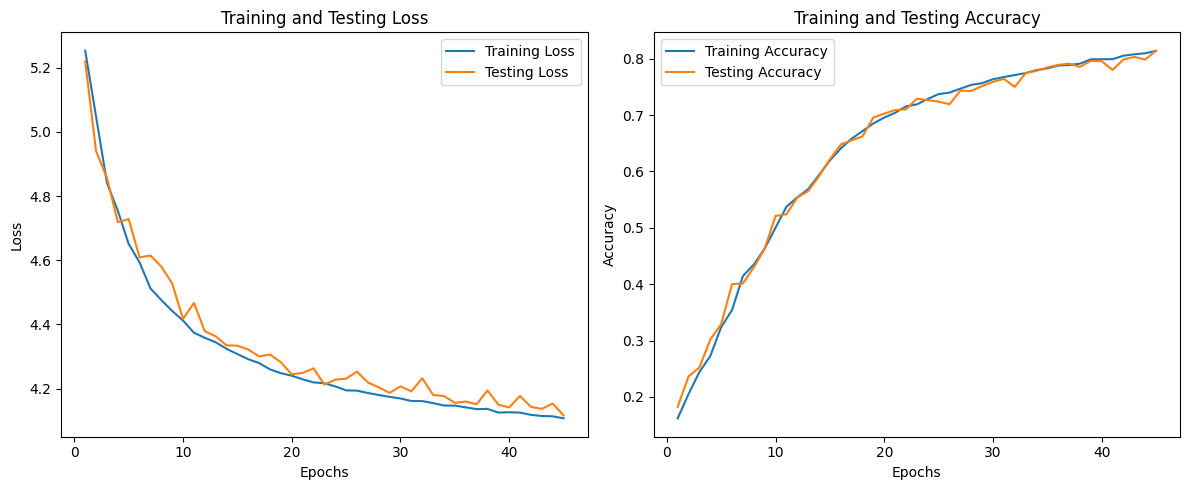

In [ ]:
import matplotlib.pyplot as plt
# Number of epochs (assuming length of lists is the number of epochs)
epochs = range(1, len(train_loss_list) + 1)

# Plot for Loss
plt.figure(figsize=(12, 5))

# First subplot for Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_list, label='Training Loss')
plt.plot(epochs, test_loss_list, label='Testing Loss')
plt.title('Training and Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Second subplot for Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy_list, label='Training Accuracy')
plt.plot(epochs, test_accuracy_list, label='Testing Accuracy')
plt.title('Training and Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Show plots
plt.tight_layout()
plt.show()


In [ ]:
max(test_accuracy_list)

0.8143028846153846